In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt

In [14]:
#Loading in the data
df = pd.read_csv("oasis_longitudinal.csv")
df

#extracting pateints only from first and second visits
df = df.loc[df['Visit'].isin([1,2])]
print(df)
print("Dataset has " + str(df.shape[0]) +" values, along " + str(df.shape[1]) +" dimensions.")
print("Participents Sex: " + str(len(df.loc[df['M/F'].isin(['M'])])) +" Males and " + str(len(df.loc[df['M/F'].isin(['F'])])) +" Females.")
print("Class distribution for demented and non-demented patients in reduced dataset is as follows:" )
print("Demented: " + str(len(df.loc[df['Group']== 'Demented'])))
print("Non-Demented: " + str(len(df.loc[df['Group']== 'Nondemented'])))
print("Converted from Non-Demented to Demented: " + str(len(df.loc[df['Group']== 'Converted'])))
# Remove all converted patients
df.drop(df[df['Group'] == 'Converted'].index, inplace = True)


    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
5    OAS2_0004  OAS2_0004_MR1  Nondemented      1         0   F    R   88   
..         ...            ...          ...    ...       ...  ..  ...  ...   
366  OAS2_0184  OAS2_0184_MR2     Demented      2       553   F    R   73   
367  OAS2_0185  OAS2_0185_MR1     Demented      1         0   M    R   80   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   

     EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.0  27.0  0.0  

In [15]:
#replacing categorical variables group and gender to numeric
df['M/F'].replace(['M', 'F'],
                        [0, 1], inplace=True)
df['Group'].replace(['Demented', 'Nondemented'],
                        [0, 1], inplace=True)
del df['CDR']
del df['Subject ID']
del df['MRI ID']
del df['Hand']
del df['Visit']
#printing correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
Group,1.000000,0.062580,0.255444,0.023407,0.261365,-0.157677,0.620999,-0.006232,0.303865,0.012848
MR Delay,0.062580,1.000000,-0.012860,0.112894,0.037122,0.005688,-0.001426,0.055494,-0.101452,-0.051590
M/F,0.255444,-0.012860,1.000000,0.085657,-0.038393,0.014865,0.171399,-0.563845,0.199500,0.554785
Age,0.023407,0.112894,0.085657,1.000000,-0.075885,0.021745,-0.021244,-0.012473,-0.523218,0.026788
EDUC,0.261365,0.037122,-0.038393,-0.075885,1.000000,-0.745276,0.215941,0.239459,0.081039,-0.222907
SES,-0.157677,0.005688,0.014865,0.021745,-0.745276,1.000000,-0.187760,-0.274676,-0.019644,0.266034
MMSE,0.620999,-0.001426,0.171399,-0.021244,0.215941,-0.187760,1.000000,-0.009065,0.369594,0.023584
eTIV,-0.006232,0.055494,-0.563845,-0.012473,0.239459,-0.274676,-0.009065,1.000000,-0.195227,-0.987594
nWBV,0.303865,-0.101452,0.199500,-0.523218,0.081039,-0.019644,0.369594,-0.195227,1.000000,0.193425
ASF,0.012848,-0.051590,0.554785,0.026788,-0.222907,0.266034,0.023584,-0.987594,0.193425,1.000000


In [16]:
list(df.columns)

['Group',
 'MR Delay',
 'M/F',
 'Age',
 'EDUC',
 'SES',
 'MMSE',
 'eTIV',
 'nWBV',
 'ASF']

Feature Extraction

In [24]:
from sklearn.feature_selection import SelectKBest, chi2, SelectFpr
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
feature_list = list(df.columns)
# target stays stable
y = df[['Group']]
y = y.iloc[1:,:].values
feature_list.remove('Group')
X = df[feature_list]
X = X.iloc[1:,:].values
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
acc_list = []

if np.sum(np.isnan(X)):
  #print('Total of NaN before imputation:', np.sum(np.isnan(X)))
  imputer = KNNImputer(n_neighbors=4, weights="uniform")
  X1 = imputer.fit_transform(X)

for j in range(20):
  acc_temp= []
  for i in range(1,10):
    select = SelectKBest(chi2, k=i)
    X_new = select.fit_transform(X1, y)
    # set aside 20% of train and test data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_new, y,
    test_size=0.2, shuffle= False)

# Use the same function above for the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25) # 0.25 x 0.8 = 0.2
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = kernels[1], probability=True))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = np.round(accuracy_score(y_val, y_pred), 3)
    acc_temp.append(acc)
    print(select.get_support())
  acc_list.append(acc_temp)

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ValueError: Item wrong length 9 instead of 268.

In [23]:
acc_list
np.mean(acc_list, axis = 0)

array([0.45735, 0.79255, 0.7824 , 0.78885, 0.7888 , 0.7898 , 0.74175,
       0.7676 , 0.77675])

In [9]:
to_plot = np.average(acc_list, axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


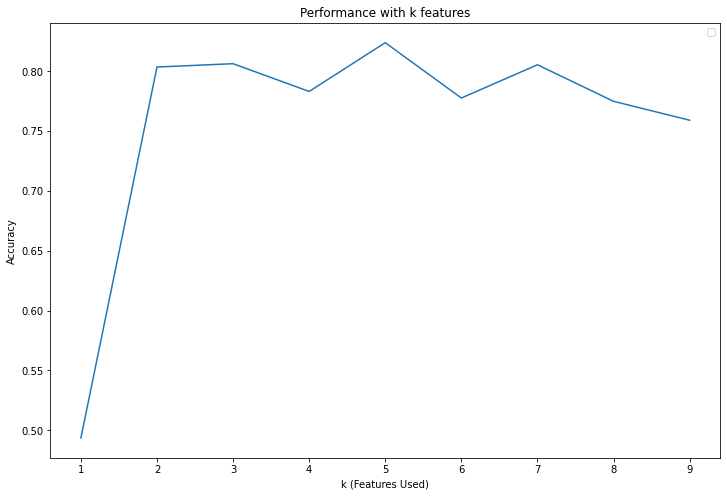

In [124]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols = 1, figsize= (12,8))

# MMSE
ax.plot(list(range(1,10)), to_plot)
ax.set_title("Performance with k features")
ax.set_xlabel("k (Features Used)")
ax.set_ylabel("Accuracy")
ax.legend()

In [34]:
#deciding to use  MMSE, nWBV, EDUC, Gender
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
import copy
df.reset_index(drop=True)

feature_list = list(df.columns)
# target stays stable
y = df[['Group']]
y = y.iloc[1:,:].values

feature_list.remove('Group')

updated_list = []


for i in range(9):
  acc_arr = []
  feature_names = []
  for j in range(len(feature_list)):
    temp_list = copy.deepcopy(updated_list)
    temp_list.append(feature_list[j])
    feature_names.append(feature_list[j])
    print(temp_list)
    X=df[temp_list]
    X = X.iloc[1:,:].values

    # check nan, data imputation
    if np.sum(np.isnan(X)):
      #print('Total of NaN before imputation:', np.sum(np.isnan(X)))
      imputer = KNNImputer(n_neighbors=3, weights="uniform")
      X1 = imputer.fit_transform(X)
      #print('Total of NaN after imputation:', np.sum(np.isnan(X1)))
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)
    ''' print("X_train size:",len(X_train), 'Shape:',X_train.shape)
    print("X_test size:",len(X_test),'Shape:',X_test.shape)
    print("y_train size:",len(y_train),'Shape:',y_train.shape)
    print("y_test size:",len(y_test),'Shape:',y_test.shape) '''

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred), 3)
    acc_arr.append(acc)

  feature_to_add = acc_arr.index(max(acc_arr))
  
  print(feature_to_add)
  print(updated_list)
  print(acc_arr)
  updated_list.append(feature_names[feature_to_add])
  feature_list.remove(feature_names[feature_to_add])

updated_list
  

['MR Delay']
['M/F']
['Age']
['EDUC']
['SES']
['MMSE']
['eTIV']
['nWBV']
['ASF']
2
[]
[0.759, 0.796, 0.889, 0.87, 0.519, 0.815, 0.833, 0.852, 0.852]
['Age', 'MR Delay']
['Age', 'M/F']
['Age', 'EDUC']
['Age', 'SES']
['Age', 'MMSE']
['Age', 'eTIV']
['Age', 'nWBV']
['Age', 'ASF']
5
['Age']
[0.759, 0.852, 0.833, 0.648, 0.815, 0.907, 0.833, 0.815]
['Age', 'eTIV', 'MR Delay']
['Age', 'eTIV', 'M/F']
['Age', 'eTIV', 'EDUC']
['Age', 'eTIV', 'SES']
['Age', 'eTIV', 'MMSE']
['Age', 'eTIV', 'nWBV']
['Age', 'eTIV', 'ASF']
0
['Age', 'eTIV']
[0.87, 0.833, 0.833, 0.5, 0.833, 0.815, 0.833]
['Age', 'eTIV', 'MR Delay', 'M/F']
['Age', 'eTIV', 'MR Delay', 'EDUC']
['Age', 'eTIV', 'MR Delay', 'SES']
['Age', 'eTIV', 'MR Delay', 'MMSE']
['Age', 'eTIV', 'MR Delay', 'nWBV']
['Age', 'eTIV', 'MR Delay', 'ASF']
0
['Age', 'eTIV', 'MR Delay']
[0.907, 0.815, 0.463, 0.87, 0.889, 0.759]
['Age', 'eTIV', 'MR Delay', 'M/F', 'EDUC']
['Age', 'eTIV', 'MR Delay', 'M/F', 'SES']
['Age', 'eTIV', 'MR Delay', 'M/F', 'MMSE']
['Age', 

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-

['Age', 'eTIV', 'MR Delay', 'M/F', 'MMSE', 'EDUC', 'SES', 'nWBV', 'ASF']

Splitting Data

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
print("X_train size:",len(X_train), 'Shape:',X_train.shape)
print("X_test size:",len(X_test),'Shape:',X_test.shape)
print("y_train size:",len(y_train),'Shape:',y_train.shape)
print("y_test size:",len(y_test),'Shape:',y_test.shape)

X_train size: 213 Shape: (213, 4)
X_test size: 54 Shape: (54, 4)
y_train size: 213 Shape: (213, 1)
y_test size: 54 Shape: (54, 1)


Decision Tree

Accuracy is: 0.722


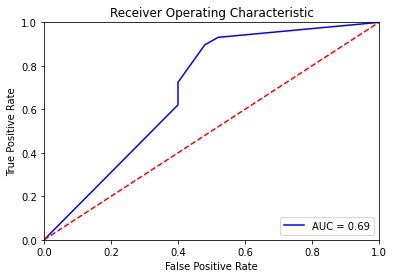

In [61]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
print("Accuracy is: " + str(acc))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SVM

In [134]:
df

,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,1,0,0,87,14,2.0,27.0,1987,0.696,0.883
1,1,457,0,88,14,2.0,30.0,2004,0.681,0.876
2,0,0,0,75,12,NaN,23.0,1678,0.736,1.046
3,0,560,0,76,12,NaN,28.0,1738,0.713,1.010
5,1,0,1,88,18,3.0,28.0,1215,0.710,1.444
...,...,...,...,...,...,...,...,...,...,...
366,0,553,1,73,16,3.0,21.0,1351,0.708,1.299
367,0,0,0,80,16,1.0,28.0,1704,0.711,1.030
368,0,842,0,82,16,1.0,28.0,1693,0.694,1.037
370,1,0,1,61,13,2.0,30.0,1319,0.801,1.331


In [140]:
y = df[['Group']]
y = y.iloc[1:,:].values
X = df[['MR Delay', 'M/F', 'EDUC', 'SES', 'MMSE']]
X = X.iloc[1:,:].values
if np.sum(np.isnan(X)):
  #print('Total of NaN before imputation:', np.sum(np.isnan(X)))
  imputer = KNNImputer(n_neighbors=4, weights="uniform")
  X1 = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)

Accuracy is: 0.815


c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


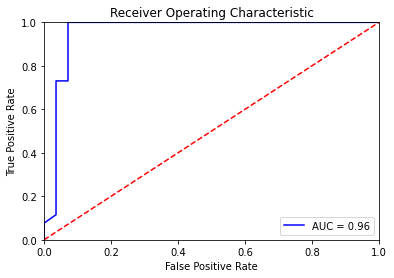

In [142]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = 'poly', probability=True))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
print("Accuracy is: " + str(acc))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy is: 0.907


c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


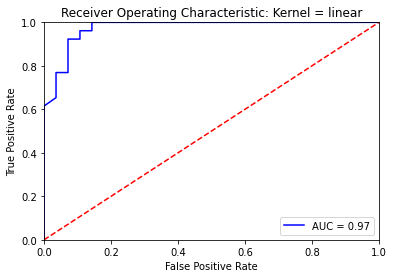

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy is: 0.815


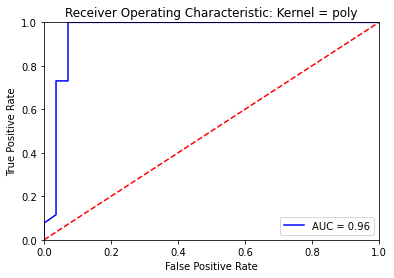

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy is: 0.87


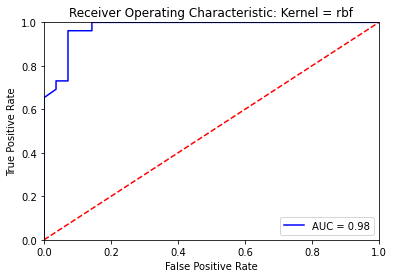

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy is: 0.87


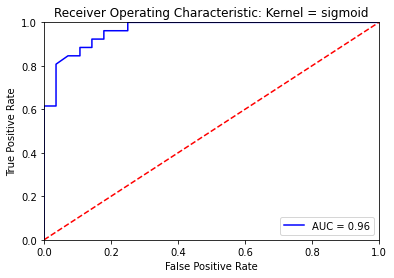

In [145]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = kernels[i], probability=True))
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  probs = clf.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  acc = np.round(accuracy_score(y_test, y_pred), 3)
  print("Accuracy is: " + str(acc))
  plt.title('Receiver Operating Characteristic: Kernel = ' + kernels[i])
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

Naive Bayes

Accuracy is: 0.889


c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


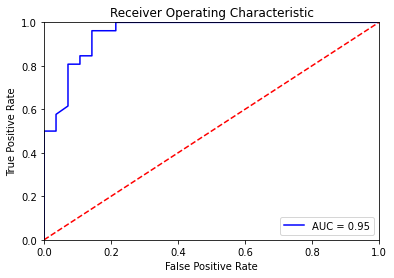

In [146]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
print("Accuracy is: " + str(acc))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

MLP

In [147]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
print("Accuracy is: " + str(acc))
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

''' clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
print("Accuracy is: " + str(acc))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() '''

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy is: 0.722
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.568 (+/-0.027) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.624 (+/-0.131) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.540 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.653 (+/-0.093) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.554 (+/-0.035) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.671 (+/-0.150) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'c

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


' clf.fit(X_train, y_train)\ny_pred = clf.predict(X_test)\nprobs = clf.predict_proba(X_test)\npreds = probs[:,1]\nfpr, tpr, threshold = metrics.roc_curve(y_test, preds)\nroc_auc = metrics.auc(fpr, tpr)\nacc = np.round(accuracy_score(y_test, y_pred), 3)\nprint("Accuracy is: " + str(acc))\nplt.title(\'Receiver Operating Characteristic\')\nplt.plot(fpr, tpr, \'b\', label = \'AUC = %0.2f\' % roc_auc)\nplt.legend(loc = \'lower right\')\nplt.plot([0, 1], [0, 1],\'r--\')\nplt.xlim([0, 1])\nplt.ylim([0, 1])\nplt.ylabel(\'True Positive Rate\')\nplt.xlabel(\'False Positive Rate\')\nplt.show() '

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


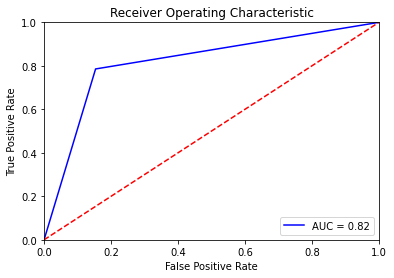

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


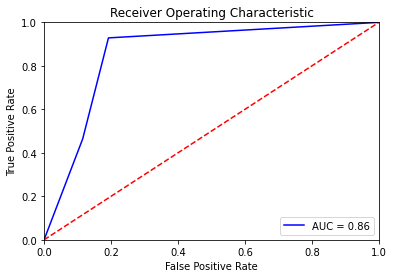

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


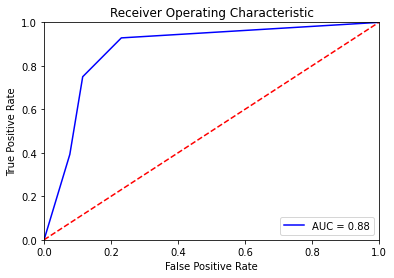

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


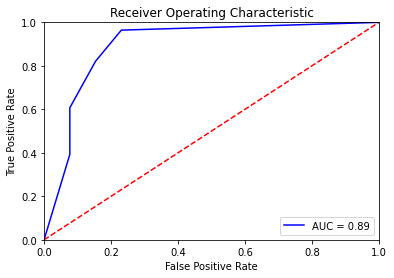

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


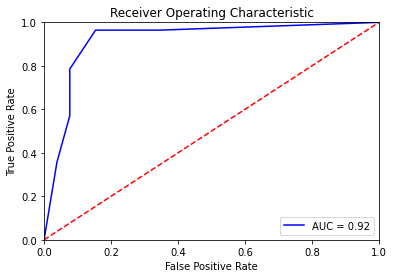

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


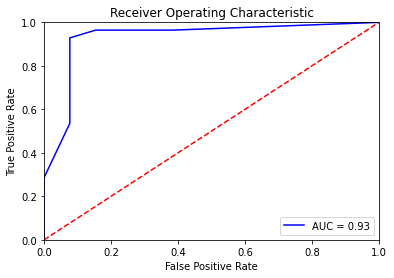

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


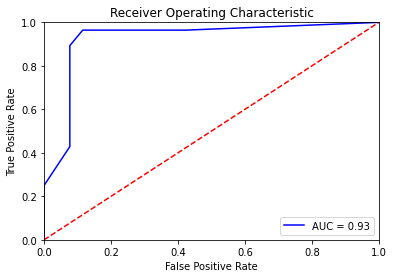

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


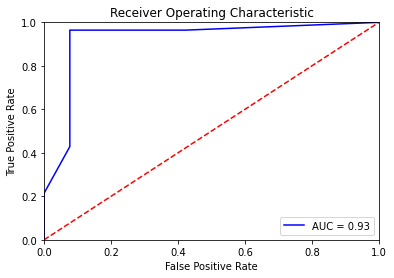

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


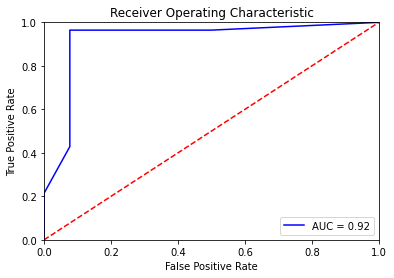

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[0.815, 0.667, 0.815, 0.759, 0.852, 0.796, 0.907, 0.87, 0.944]
Best # of neibhors is  9
Best P(classification) = 0.944
Confusion matrix: 
 [[24  2]
 [ 1 27]]


array([1], dtype=int64)

In [12]:
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics
b = []
for i in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  probs = knn.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  acc = np.round(accuracy_score(y_test, y_pred), 3)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  b.append(acc)
  #print("P(classification) =", a)
  #print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print(b)
c = b.index(max(b))+1

knnc = KNeighborsClassifier(n_neighbors=c).fit(X_train, y_train)
y_predc = knnc.predict(X_test)
ac = np.round(accuracy_score(y_test, y_predc), 3)
print("Best # of neibhors is ",c)
print("Best P(classification) =", ac)
print("Confusion matrix: \n", confusion_matrix(y_test, y_predc))
#MMSE, nWBV, EDUC, Gender
knnc.predict([[29,.713,14,1]])

c:\Users\udayr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


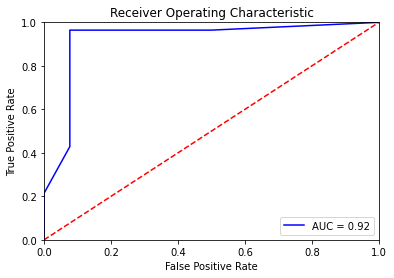

In [10]:
knn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
y_pred = knn.predict(X_test)
probs = knn.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
acc = np.round(accuracy_score(y_test, y_pred), 3)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()